In [1]:
MAIN_PATH = "/home/carlos/MasterDS/tfm"
JSON_DATA_PATH = '{}/data/json/'.format(MAIN_PATH)
CSV_DATA_PATH = '{}/data/csv/'.format(MAIN_PATH)

In [2]:
import sys
sys.path.insert(0, MAIN_PATH)

In [3]:
%load_ext autoreload
%autoreload 2
from scripts.extractive_summary.ltr.ltr_features_targets import LTRFeaturesTargets
from scripts.text.article_text_processor import ArticleTextProcessor
from scripts.models.ltr.train import LTRTrain

from scripts.conf import TEAMS
%reload_ext autoreload

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

# Exploratorio: transformaciones

Como hemos visto con el exploratorio inicial, algunas de las features
que tenemos van a necesitar algún tipo de procesado, además de que la
presencia de correlaciones va a hacer que tengamos que elegir entre
algunas.

In [5]:
key_events = ['goal', 'red_card', 'penalty']
lags = [1, 3, 5]
target_metric = 'rouge'
drop_teams = True
lemma = True
metric_params = {'rouge_mode': 'rouge-1', 'rouge_metric': 'r'}
#metric_params = {'ngram_range': (1, 2), 'strip_accents': 'unicode'}
count_vec_kwargs = {'ngram_range': (1, 2), 'strip_accents': 'unicode'}

train_perc = 0.7
val_perc = 0.2

In [8]:
ltr = LTRFeaturesTargets(target_metric=target_metric, 
                        key_events=key_events,
                        lags=lags,
                        metric_params=metric_params,
                        count_vec_kwargs=count_vec_kwargs,
                        drop_teams=drop_teams,
                        lemma=lemma)

Setting target metric to rouge


In [8]:
ltr.run_target_features()

/home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/features_targets.csv already exists


In [9]:
ltr.train_val_test_split(train_perc=train_perc, val_perc=val_perc)

Train, val and test data are already written


In [9]:
pd_train = ltr.read_train()

Reading /home/carlos/MasterDS/tfm/data/ltr/features_targets/341d2aa93d/train.csv


## Número de jugadores

- En algunos eventos, no somos capaces de identificar a los jugadores.
Esto implica que alrededor del 9% de los eventos no van a tener jugador 
asociado, por lo que la variable players_importance también será 0.

- El número máximo de jugadores es de 3, y si pintamos la distribución
del target en cada categoría, se puede observar que, a más jugadores, mas probabilidad de entrar en el artículo. Esto también podría deberse a que
si hay más jugadores, probablemente haya más palabras, y el score va a subir cuantas mas palabras haya en el evento, porque contabiliza cuantas de las palabras de una frase del artículo están en el resumen.

- No hay una relación muy clara entre la importancia de los jugadores
y el score

Teniendo esto en cuenta, se propone:
- No usar la variable players_importance
- Recategorizar la variable n_players en 3 tramos: sin jugador, 1 jugador y más de un jugador.

In [16]:
pd_train[['n_players', 'score']].groupby('n_players').describe()

score                                                         \
              count      mean       std  min       25%       50%       75%   
n_players                                                                    
0           26007.0  0.092625  0.122701  0.0  0.000000  0.066667  0.142857   
1          202827.0  0.113123  0.128267  0.0  0.000000  0.095238  0.166667   
2           67572.0  0.174031  0.152082  0.0  0.076923  0.153846  0.250000   
3             254.0  0.256353  0.220919  0.0  0.111111  0.200000  0.333333   

                
           max  
n_players       
0          1.0  
1          1.0  
2          1.0  
3          1.0

<AxesSubplot:xlabel='n_players', ylabel='score'>

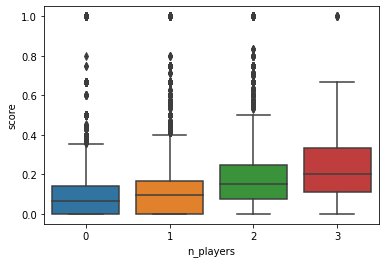

In [14]:
sns.boxplot(x='n_players',y='score', data=pd_train)

In [17]:
pd_train[['n_players', 'players_importance']].groupby('n_players').describe()

players_importance                                          \
                       count      mean       std       min       25%   
n_players                                                              
0                    26007.0  0.000000  0.000000  0.000000  0.000000   
1                   202827.0  0.001004  0.001528  0.000002  0.000219   
2                    67572.0  0.002340  0.003199  0.000004  0.000763   
3                      254.0  0.001689  0.002430  0.000009  0.000522   

                                         
                50%       75%       max  
n_players                                
0          0.000000  0.000000  0.000000  
1          0.000631  0.001293  0.091837  
2          0.001730  0.002884  0.173469  
3          0.000811  0.001535  0.019152

<AxesSubplot:xlabel='n_players', ylabel='players_importance'>

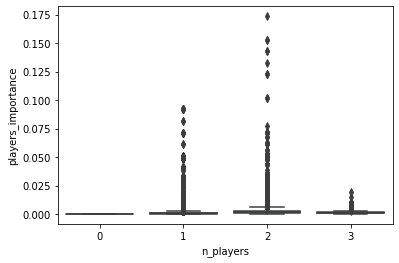

In [18]:
sns.boxplot(x='n_players',y='players_importance', data=pd_train)

<AxesSubplot:xlabel='players_importance', ylabel='score'>

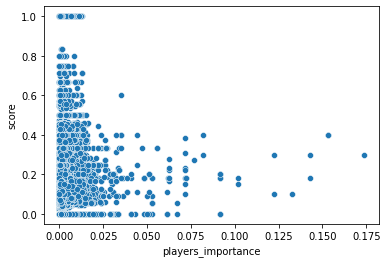

In [19]:
sns.scatterplot(x='players_importance', y='score', data=pd_train)

In [20]:
pd_train_proc = pd_train.copy()

In [22]:
pd_train_proc['n_players_cat'] = pd_train_proc['n_players'].apply(lambda x: 'no_player' if x==0 else 'one_player' if x==1 else 'more_than_one_player')

In [23]:
pd_train_proc[['n_players_cat', 'score']].groupby('n_players_cat').describe()

score                                               \
                         count      mean       std  min       25%       50%   
n_players_cat                                                                 
more_than_one_player   67826.0  0.174339  0.152478  0.0  0.076923  0.153846   
no_player              26007.0  0.092625  0.122701  0.0  0.000000  0.066667   
one_player            202827.0  0.113123  0.128267  0.0  0.000000  0.095238   

                                     
                           75%  max  
n_players_cat                        
more_than_one_player  0.250000  1.0  
no_player             0.142857  1.0  
one_player            0.166667  1.0

<AxesSubplot:xlabel='n_players_cat', ylabel='score'>

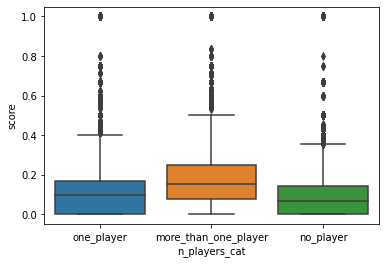

In [24]:
sns.boxplot(x='n_players_cat',y='score', data=pd_train_proc)

# Eventos clave, ventaja e igualada

Estas 3 variables categóricas describen eventos claves dentro de un partido. Es muy probable que la información de ventaja e igualada esté 
dentro de la de eventos clave, pues se buscan los goles.

Se examinan estas variables en función del objetivo:

- La relación con los eventos clave es clara: si ocurre, es muy probable
que esté dentro de los artículos.

- Con incluir la variable de eventos clave bastaría

In [25]:
pd_train[['is_key_event', 'score']].groupby('is_key_event').describe()

score                                                         \
                 count      mean       std  min       25%       50%       75%   
is_key_event                                                                    
0             286957.0  0.120473  0.133079  0.0  0.000000  0.100000  0.181818   
1               9703.0  0.268727  0.156648  0.0  0.166667  0.230769  0.333333   

                   
              max  
is_key_event       
0             1.0  
1             1.0

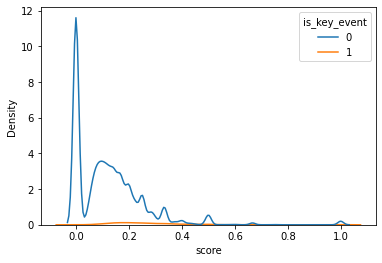

In [10]:
sns.kdeplot(x='score', hue='is_key_event', data=pd_train);

<AxesSubplot:xlabel='is_key_event', ylabel='score'>

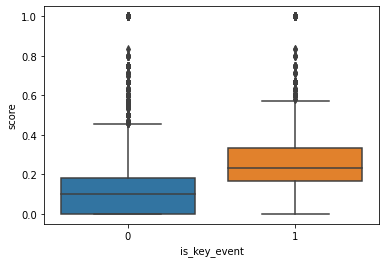

In [26]:
sns.boxplot(x='is_key_event',y='score', data=pd_train)

In [28]:
pd_train[['advantage', 'score']].groupby('advantage').describe()

score                                                         \
              count      mean       std  min       25%       50%       75%   
advantage                                                                    
0          288938.0  0.121432  0.133748  0.0  0.000000  0.100000  0.181818   
1            7722.0  0.270874  0.156782  0.0  0.166667  0.238095  0.333333   

                
           max  
advantage       
0          1.0  
1          1.0

<AxesSubplot:xlabel='advantage', ylabel='score'>

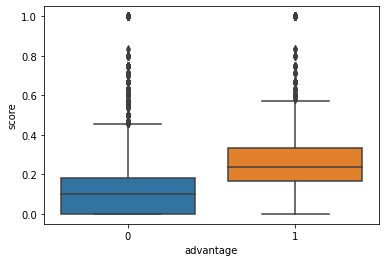

In [29]:
sns.boxplot(x='advantage',y='score', data=pd_train)

In [30]:
pd_train[['equalize', 'score']].groupby('equalize').describe()

score                                                            
             count      mean       std  min       25%       50%       75%  max
equalize                                                                      
0         295020.0  0.124566  0.135952  0.0  0.000000  0.105263  0.181818  1.0
1           1640.0  0.261429  0.162036  0.0  0.153846  0.222222  0.333333  1.0

<AxesSubplot:xlabel='equalize', ylabel='score'>

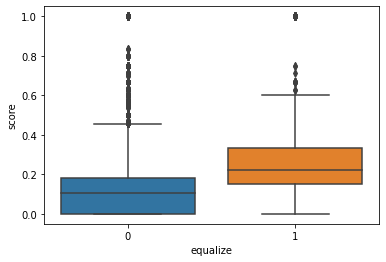

In [31]:
sns.boxplot(x='equalize',y='score', data=pd_train)

## Longitud y stopwords

Con estas variables se intenta ver si el hecho de que un evento sea más largo que otro influye en la probabilidad de aparecer en el resumen final. Intuitivamente esto será así, por cómo se ha construido el target (en el caso de usar rouge).

Evidentemente están muy correladas, por lo que podemos o eliminar una
de las dos o crear una variable nueva que sea la suma de ambas, y que 
realmente simboliza la longitud del evento.

In [83]:
pd_corr = pd_train[['length', 'n_stop', 'score']].corr()

<AxesSubplot:>

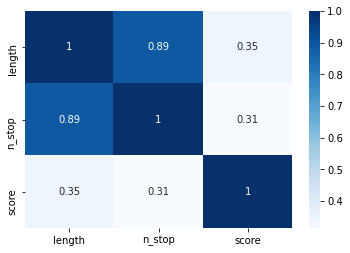

In [37]:
sns.heatmap(pd_corr, annot=True, cmap='Blues')

In [84]:
pd_train_proc = pd_train.copy()

In [85]:
pd_train_proc['len_event'] = pd_train_proc['length'] + pd_train_proc['n_stop']

In [42]:
pd_corr = pd_train_proc[['len_event', 'score']].corr()

<AxesSubplot:>

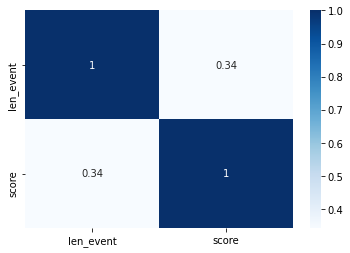

In [43]:
sns.heatmap(pd_corr, annot=True, cmap='Blues')

Además, se observa que esta variable está muy correlada con tfidf_sum, también de forma lógica. Habrá que escoger entre una de las dos.

In [86]:
pd_corr = pd_train_proc[['len_event', 'tfidf_sum', 'score']].corr()

<AxesSubplot:>

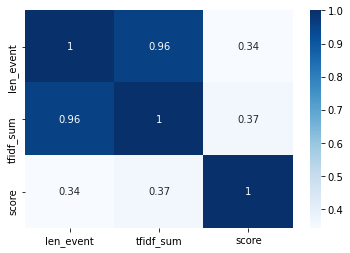

In [87]:
sns.heatmap(pd_corr, annot=True, cmap='Blues')

## Similaridad con eventos anteriores

Atendiendo a las distribuciones, están muy sesgadas hacia el cero, lo que significa que los eventos consecutivos en general no comparten términos.

Examinamos la distribución al ignorar los ceros:
- Presentan distribuciones muy similares -> es probable que no haga falta
irse hasta 5 eventos más atrás para encontrar la similaridad.

In [44]:
sim_cols = [col for col in pd_train.columns if 'sim' in col]

count    77865.000000
mean         0.198573
std          0.178537
min          0.005704
25%          0.058632
50%          0.147139
75%          0.282291
max          1.000000
Name: sim_previous_1, dtype: float64
count    90580.000000
mean         0.211240
std          0.191611
min          0.004261
25%          0.076393
50%          0.150456
75%          0.281858
max          1.000000
Name: sim_previous_3, dtype: float64
count    86534.000000
mean         0.208896
std          0.190292
min          0.005746
25%          0.075243
50%          0.149442
75%          0.278120
max          1.000000
Name: sim_previous_5, dtype: float64


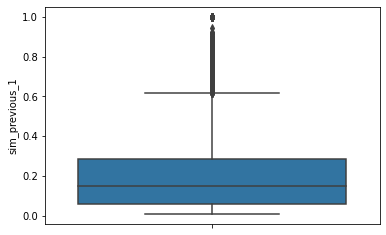

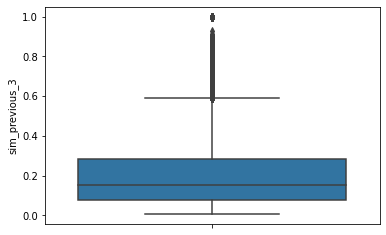

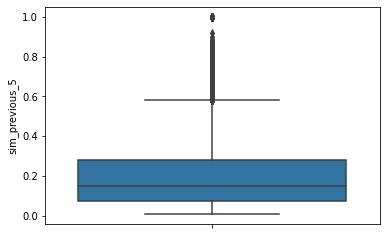

In [51]:
for col in sim_cols:
    print(pd_train[pd_train[col]!=0][col].describe())
    fig, ax = plt.subplots()
    sns.boxplot(y=col, data=pd_train[pd_train[col]!=0], ax=ax)
    plt.plot()

No hay correlación lineal entre los valores distintos de cero de la
similaridad y el target...

In [52]:
pd_sim_1 = pd_train[pd_train['sim_previous_1']!=0][['sim_previous_1', 'score']]

In [53]:
pd_corr = pd_sim_1.corr()

<AxesSubplot:>

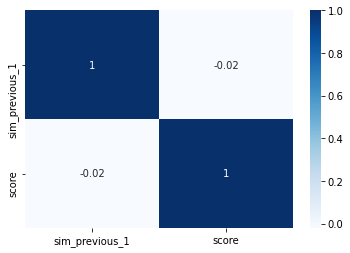

In [54]:
sns.heatmap(pd_corr, annot=True, cmap='Blues')

Probamos a discretizar la variable en dos rangos: sin y con similaridad.

In [55]:
pd_train_proc = pd_train.copy()
pd_train_proc['sim_previous_1_cat'] = pd_train_proc['sim_previous_1'].apply(lambda x: '0' if x==0 else '1')

<AxesSubplot:xlabel='sim_previous_1_cat', ylabel='score'>

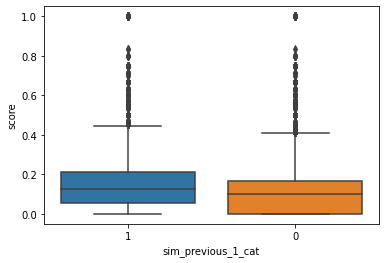

In [56]:
sns.boxplot(x='sim_previous_1_cat', y='score', data=pd_train_proc)

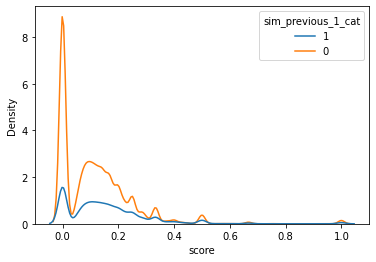

In [61]:
sns.kdeplot(x='score', hue='sim_previous_1_cat', data=pd_train_proc);

Las distribuciones son muy parecidas... Se puede probar a incluir en el 
modelo, aunque no parece que vaya a ayudar demasiado.

__Otros procesados__

Además de lo mencionado anteriormente, se procede a:

- Eliminar la variable position por no aportar información

# Análisis transformaciones

In [99]:
ltr_params = {
    'key_events': ['goal', 'red_card', 'penalty'],
    'lags': [1, 3, 5],
    'target_metric': 'rouge',
    'drop_teams': True,
    'lemma': True,
    'metric_params': {'rouge_mode': 'rouge-1', 'rouge_metric': 'r'},
    'count_vec_kwargs': {'ngram_range': (1, 2), 'strip_accents': 'unicode'}
}
features = ['is_key_event', 'n_players_cat', 'tfidf_sum']
model_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'bootstrap': True,
    
}

In [100]:
ltr_train = LTRTrain(features, model_params, ltr_params)

Setting target metric to rouge


In [101]:
ltr_train.config()

{'cv': 0,
 'opt_metric': '',
 'features': ['is_key_event', 'n_players_cat', 'tfidf_sum'],
 'n_estimators': 100,
 'max_depth': 5,
 'bootstrap': True,
 'key_events': ['goal', 'red_card', 'penalty'],
 'lags': [1, 3, 5],
 'target_metric': 'rouge',
 'drop_teams': True,
 'lemma': True,
 'metric_params': {'rouge_mode': 'rouge-1', 'rouge_metric': 'r'},
 'count_vec_kwargs': {'ngram_range': (1, 2), 'strip_accents': 'unicode'}}

In [102]:
ltr_train.path

'/home/carlos/MasterDS/tfm/models/ltr_random_forest/4d8de6520a'

In [65]:
pd_train = ltr_train.train_data()

Reading /home/carlos/MasterDS/tfm/data/csv/summaries/ltr/features_targets/341d2aa93d/train.csv


In [88]:
pd_train_proc = ltr_train.preprocess_data(pd_train)

Categorizing n_players...
Computing new length...
Dropping {'players_importance', 'event_ix', 'n_stop', 'advantage', 'length', 'position', 'sim_previous_1', 'url', 'sentence_ix', 'sim_previous_3', 'json_file', 'sim_previous_5', 'equalize', 'total_length', 'n_players'}


In [89]:
pd_train_proc

,is_key_event,n_players_cat,tfidf_sum,score
0,0,one_player,3.512653,0.166667
1,0,one_player,2.198599,0.000000
2,0,more_than_one_player,5.068378,0.200000
3,0,one_player,2.558036,0.333333
4,0,one_player,2.188177,0.000000
...,...,...,...,...
296655,0,one_player,3.147186,0.500000
296656,0,one_player,3.549072,0.083333
296657,0,one_player,3.655166,0.100000
296658,0,one_player,2.206885,0.000000


In [90]:
profile = ProfileReport(pd_train_proc, title='Pandas Profiling Report', explorative=True)
profile.to_notebook_iframe()